In [1]:
from torchvision.models import vgg16
from torchvision import transforms
import torch
import torch.nn as nn
from torch.autograd import Variable
import urllib, urllib2, cStringIO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pickle
from dataset import *
import pandas as pd

%matplotlib inline

In [26]:
df = pd.read_csv('data/pose_class/data_train_0.csv')
df['genus'].value_counts(normalize=True).sort_index().values
# classes = sorted(df['genus'].unique())
# [df['genus'].value_counts(cls) for cls in classes]

array([0.02086344, 0.03138102, 0.01372294, 0.05656597, 0.11968576,
       0.01330796, 0.02209407, 0.01266402, 0.10975488, 0.01508235,
       0.0421991 , 0.10808065, 0.13738678, 0.02126411, 0.04277149,
       0.01438118, 0.09617504, 0.11351831, 0.00910093])

In [105]:
vgg_model = vgg16(pretrained=True)

In [106]:
class2idx = eval(str(pickle.load(urllib2.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))))
class2idx

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

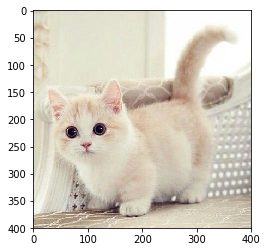

In [153]:
url = 'http://img0.pclady.com.cn/pclady/pet/choice/cat/1701/6.jpg'
# url = 'https://vignette.wikia.nocookie.net/drzhark/images/a/aa/Puppy1.jpg/revision/latest/scale-to-width-down/640?cb=20170402182604'
f = cStringIO.StringIO(urllib.urlopen(url).read())
img = Image.open(f)
# img = np.array(img, dtype=np.float32) / 255.
plt.imshow(img)

In [154]:
trfm = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
inp = trfm(img).unsqueeze(0)
inp = Variable(inp)
inp.size()

torch.Size([1, 3, 224, 224])

In [165]:
output = vgg_model(inp)
print(output)
_, cls_idx = torch.max(output, 1)
class2idx[cls_idx.data[0]]

Variable containing:
 -4.5822  -0.0576  -4.6494  ...   -3.8529   5.0922   7.5356
[torch.FloatTensor of size 1x1000]



'Angora, Angora rabbit'

In [166]:
class MyVGG16(nn.Module):
    def __init__(self):
        super(MyVGG16, self).__init__()
        vgg_model = vgg16(pretrained=True)
        self.features = vgg_model.features
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Conv2d(4096, 19, kernel_size=6)
        )
        
        self.classifier[0].weight = torch.nn.Parameter(vgg_model.classifier[0].weight.view(4096, 512, 7, 7).data)
        self.classifier[0].bias = torch.nn.Parameter(vgg_model.classifier[0].bias.data)
        self.classifier[3].weight = torch.nn.Parameter(vgg_model.classifier[3].weight.view(4096, 4096, 1, 1).data)
        self.classifier[3].bias = torch.nn.Parameter(vgg_model.classifier[3].bias.data)
        self.classifier[6].weight = torch.nn.Parameter(vgg_model.classifier[6].weight.view(1000, 4096, 1, 1).data)
        self.classifier[6].bias = torch.nn.Parameter(vgg_model.classifier[6].bias.data)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        x = x.view(x.size(0), -1)
        
        return x

myvgg_model = MyVGG16()

In [160]:
output = myvgg_model(inp)
print(output)
_, cls_idx = torch.max(output, 1)
class2idx[cls_idx.data[0]]

Variable containing:
-5.9674e+00 -4.3169e-01 -1.9315e+00  ...  -4.4153e+00  2.6666e+00  6.1396e+00
[torch.FloatTensor of size 1x1000]



'Angora, Angora rabbit'

In [168]:
dummy_input = Variable(torch.randn(5, 3, 384, 384))
output = myvgg_model(dummy_input)
output.size()

torch.Size([5, 19])

In [2]:
dummy_input = Variable(torch.randn(4, 3, 32, 32))
net = resnet50()
torch.onnx.export(net, dummy_input, "tmp/resnet50.onnx")

NameError: name 'Variable' is not defined